# Actividad 3
## Percepción Computacional
## Evaluación de la segmentación

### Luis Rafael Castillo Rico

Este es el notebook donde implementé los 2 segmentadores, ambos códigos siguen, a grandes rasgos, los siguientes pasos:

- Preprocesamiento de la imagen: Este es para mejorar la calidad de la imagen antes de la segmentación. Se puede aplicar un filtro para reducir el ruido o mejorar el contraste.

- Segmentación: Se puede utilizar un algoritmo de segmentación para identificar las áreas en la imagen que contienen aves.

- Filtrado: Finalmente, se puede usa un  filtro donde se eliminan los contornos que no cumplen las características requeridas para ser segmentados.

Finalmente en la sección se evaluación se determina el desempeño de los segmentadores, las imágenes de ground truth se adjuntan en la entrega y deben ser colocadas en la misma carpeta que este notebook, junto con las imágenes originales.

In [1]:
# importando librerías
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

Puede escogerse la imagen1.jpg o la imagen2.jpg adjuntadas en la entrega

### Segmentador 1

Este código carga una imagen, la convierte a escala de grises, aplica un filtro Gaussiano para reducir el ruido y luego utiliza la segmentación basada en umbrales para identificar las áreas de la imagen que contienen aves. A continuación, se encuentran los contornos en la imagen segmentada y se dibujan sobre la imagen original.

In [2]:
def segmentador1(indice):

    # Cargar la imagen
    img = cv2.imread(f'Imagen{indice}.jpg')

    # Convertir la imagen a escala de grises
    gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Aplicar un filtro Gaussiano para reducir el ruido
    gris = cv2.GaussianBlur(gris, (5, 5), 0)

    # Aplicar la segmentación basada en regiones
    _, umbral = cv2.threshold(gris, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contornos, _ = cv2.findContours(umbral, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Crear una máscara para la región de interés
    mascara = np.zeros_like(gris)
    for contorno in contornos:
        area = cv2.contourArea(contorno)
        # filtro
        if area > 100 and area < 900: 
            cv2.drawContours(mascara, [contorno], 0, 255, -1)
            cv2.fillPoly(img, pts =[contorno], color=(255,255,255))

    # Aplicar la máscara a la imagen original
    resultado = cv2.bitwise_and(img, img, mask=mascara)

    # Guardar la imagen
    cv2.imwrite(f'segmentador1_imagen{indice}.png', resultado)

### Segmentador 2

Este segmentador se puede considerar un segmentador por bordes y regiones de interés. En particular, utiliza técnicas de procesamiento de imágenes para detectar bordes y líneas utilizando el operador Sobel y la transformada de Hough, también utiliza la función cv2.findContours para detectar las regiones de interés en la imagen.

In [3]:
def segmentador2(indice):

    # Cargar la imagen y convertirla a escala de grises
    imagen = cv2.imread(f"Imagen{indice}.jpg")
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    # Aplicar un filtro gaussiano para reducir el ruido
    suavizado = cv2.GaussianBlur(gris, (5, 5), 0)

    # Aplicar un operador Sobel para detectar los bordes
    sobelx = cv2.Sobel(suavizado, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(suavizado, cv2.CV_64F, 0, 1, ksize=3)
    mag = np.sqrt(sobelx**2 + sobely**2)
    mag = np.uint8(mag/mag.max()*255)

    # Aplicar un umbral para binarizar la imagen con los bordes detectados
    umbral = cv2.threshold(mag, 50, 255, cv2.THRESH_BINARY)[1]

    # Realizar una operación de erosión para cerrar los bordes
    kernel = np.ones((3,3),np.uint8)
    erosionado = cv2.erode(umbral,kernel,iterations = 1)

    # Realizar una operación de dilatación para cerrar los bordes
    kernel = np.ones((3,3),np.uint8)
    dilatado = cv2.dilate(erosionado,kernel,iterations = 1)

    # Detectar líneas en la imagen utilizando la transformada de Hough
    lineas = cv2.HoughLinesP(dilatado, 1, np.pi/180, 100, minLineLength=10, maxLineGap=100)

    # Dibujar las líneas detectadas sobre la imagen original
    for linea in lineas:
        x1, y1, x2, y2 = linea[0]
        cv2.line(imagen, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Detectar regiones de interés en la imagen
    contornos, _ = cv2.findContours(dilatado, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Crear una máscara para la región de interés
    mascara = np.zeros_like(gris)
    for contorno in contornos:
        area = cv2.contourArea(contorno)
        if area > 100 and area < 5000000: #500 y 5000 para las demás imágenes
            cv2.drawContours(mascara, [contorno], 0, 255, -1)
            cv2.fillPoly(imagen, pts =[contorno], color=(255,255,255))

    # Aplicar la máscara a la imagen original
    resultado = cv2.bitwise_and(imagen, imagen, mask=mascara)

    # Guardar la imagen
    cv2.imwrite(f'segmentador2_imagen{indice}.png', resultado)

### Evaluación

In [4]:
evaluacion = []

for i in [1,2,3]:

    # Correr funciones
    segmentador1(i)
    segmentador2(i)

    # Cargar imágenes
    imagen_seg1 = cv2.imread(f'segmentador1_imagen{i}.png')
    imagen_seg2 = cv2.imread(f'segmentador2_imagen{i}.png')
    ground_truth = cv2.imread(f'Ground_truth{i}.png')

    # Convertir las imágenes a conjuntos de píxeles
    set1 = set(map(tuple,np.argwhere(imagen_seg1)))
    set2 = set(map(tuple,np.argwhere(imagen_seg2)))
    setgt = set(map(tuple,np.argwhere(ground_truth)))

    # Calcular el índice de Jaccard
    interseccion1 = len(set1.intersection(setgt))
    union1 = len(set1.union(setgt))
    interseccion2 = len(set2.intersection(setgt))
    union2 = len(set2.union(setgt))
    indice_jaccard1 = interseccion1 / union1
    indice_jaccard2 = interseccion2 / union2
    
    evaluacion.append([indice_jaccard1,indice_jaccard2])
resultados = pd.DataFrame(evaluacion, columns=['Segmentador 1', 
                                               'Segmentador 2'], 
                                      index = ['Imagen 1','Imagen 2', 'Imagen 3'])
display(resultados)

,Segmentador 1,Segmentador 2
Imagen 1,0.728578,0.553990
Imagen 2,0.470584,0.401794
Imagen 3,0.301565,0.500000


Mostrar las imágenes

IMAGEN 1


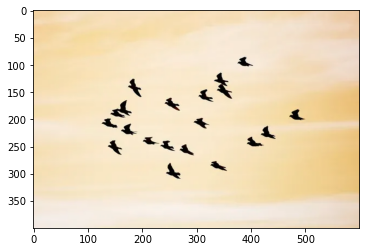

GROUND TRUTH


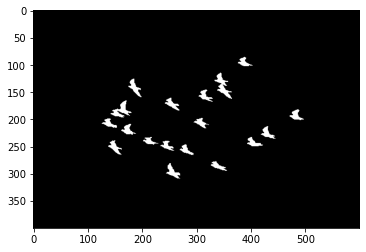

SEGMENTADOR 1


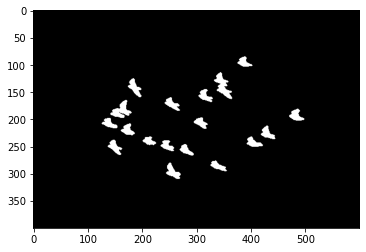

SEGMENTADOR 2


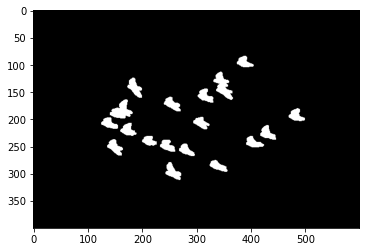

IMAGEN 2


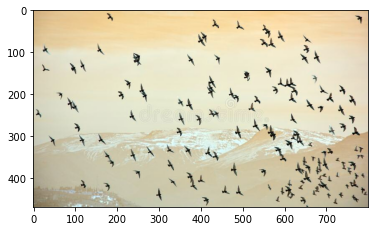

GROUND TRUTH


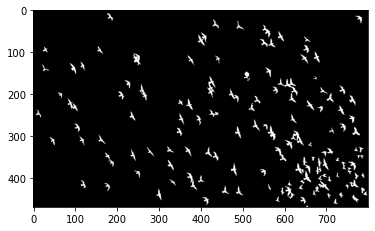

SEGMENTADOR 1


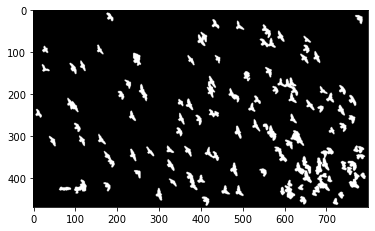

SEGMENTADOR 2


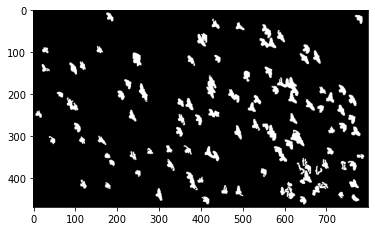

IMAGEN 3


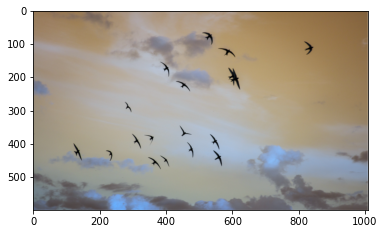

GROUND TRUTH


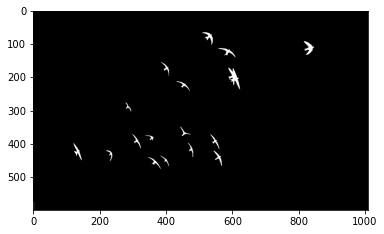

SEGMENTADOR 1


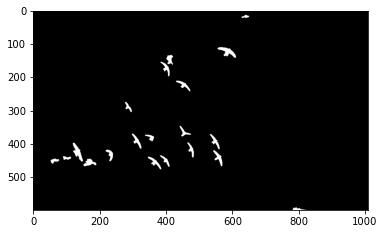

SEGMENTADOR 2


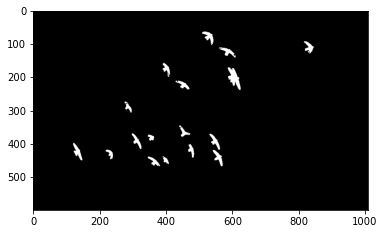

In [5]:
for i in [1,2,3]:
    print(f'IMAGEN {i}')
    plt.imshow(cv2.imread(f'Imagen{i}.jpg'))
    plt.show()
    print('GROUND TRUTH')
    plt.imshow(cv2.imread(f'Ground_truth{i}.png'))
    plt.show()
    print('SEGMENTADOR 1')
    plt.imshow(cv2.imread(f'segmentador1_imagen{i}.png'))
    plt.show()
    print('SEGMENTADOR 2')
    plt.imshow(cv2.imread(f'segmentador2_imagen{i}.png'))
    plt.show()